# Movie Recommendation System: Predicting Ratings with SVD++

**A Data Science Project for the [ALX Kaggle Challenge](https://www.kaggle.com/competitions/alx-movie-recommendation-project-2025)**

This notebook presents a movie recommendation system built to predict user ratings based on a dataset of user-movie interactions. Using matrix factorization with SVD++, I achieved an RMSE of 0.8 on the test set. Here, I explore the data, preprocess it, and apply the model, showcasing my approach to solving this challenge.

- **Dataset**: Train (User ID, Movie ID, Rating, Timestamp) | Test (User ID, Movie ID)
- **Goal**: Predict missing ratings in the test set
- **Tools**: Python, Pandas, Matplotlib, Seaborn, Surprise
- **Author**: Zakaria ELYAZGHI
- **Date**: April 2025

## Exploratory Data Analysis (EDA)

In this section, I explore the training and test datasets to uncover patterns, distributions, and characteristics that inform the recommendation system. The train dataset contains user IDs, movie IDs, and ratings, while the test dataset includes user IDs and movie IDs for predicting ratings. The goal is to understand the data’s structure, sparsity, and rating behaviors to justify the use of SVD++ and identify any preprocessing needs.

### Key Questions
- **Rating Distribution**: How are ratings distributed in the train set? Are there biases toward high or low scores?
- **User and Movie Activity**: Which users rate the most movies, and which movies receive the most ratings? How sparse is the data?
- **Dataset Scale**: How many unique users and movies are there? What’s the overall size of the train and test sets?
- **Consistency Check**: Are there anomalies (e.g., unexpected rating values) or mismatches between train and test?

### Approach
- Visualize the distribution of ratings to assess user tendencies.
- Analyze the number of ratings per user and per movie to highlight sparsity and outliers.
- Summarize key statistics (e.g., total ratings, unique users, unique movies).
- Investigate any irregularities that could affect modeling.

Findings from this analysis will guide preprocessing decisions and provide insights into the dataset’s challenges, such as sparsity or uneven rating patterns.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Set plotting style for better visuals
plt.style.use('seaborn')

### Loading the Data
Load train and test datasets to inspect their structure.

In [2]:
# Load train and test datasets (adjust file paths as needed)
train_df = pd.read_csv('train.csv')  # Columns: user_id, movie_id, rating, timestamp
test_df = pd.read_csv('test.csv')    # Columns: user_id, movie_id

# Display first few rows to verify loading
print("Train Data Sample:")
print(train_df.head(3))
print("\nTest Data Sample:")
print(test_df.head(3))

Train Data Sample:
   userId  movieId  rating   timestamp
0    5163    57669     4.0  1518349992
1  106343        5     4.5  1206238739
2  146790     5459     5.0  1076215539

Test Data Sample:
   userId  movieId
0       1     2011
1       1     4144
2       1     5767


### Unique users and movies in train and test datasets

In [3]:
n_users_train = train_df['userId'].nunique()
n_movies_train = train_df['movieId'].nunique()
n_ratings = len(train_df)

n_users_test = test_df['userId'].nunique()
n_movies_test = test_df['movieId'].nunique()
n_ratings_to_predict = len(test_df)

print(f"\nTrain: {n_users_train} unique users, {n_movies_train} unique movies, {n_ratings} ratings")
print(f"Test: {n_users_test} unique users, {n_movies_test} unique movies, {n_ratings_to_predict} ratings to predict")


Train: 162541 unique users, 48213 unique movies, 10000038 ratings
Test: 162350 unique users, 39643 unique movies, 5000019 ratings to predict


### Ratings histogram and statistics

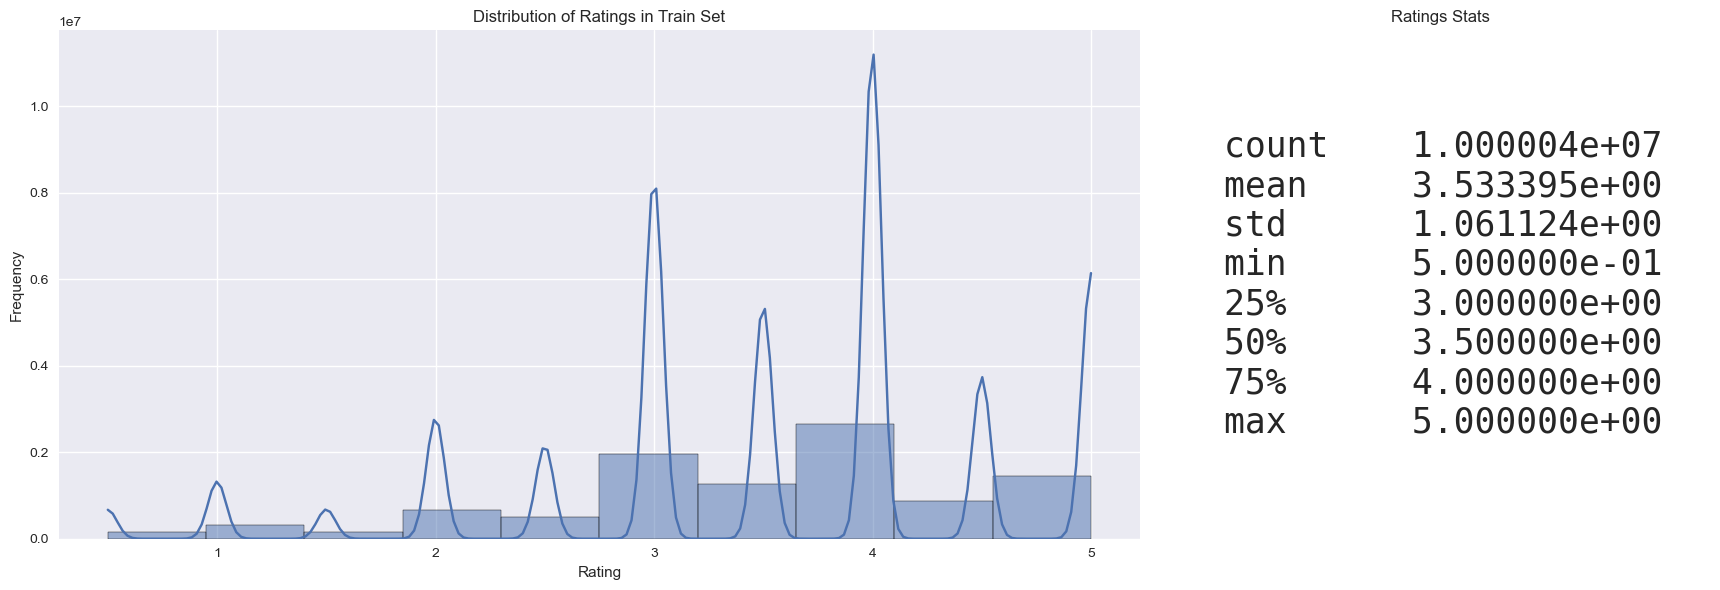

In [4]:
# Create figure with 3 subplots in one row
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6), gridspec_kw={'width_ratios': [2, 0, 1]})

# Plot histogram of ratings
sns.histplot(train_df['rating'], bins=10, kde=True, ax=ax1)
ax1.set_title('Distribution of Ratings in Train Set')
ax1.set_xlabel('Rating')
ax1.set_ylabel('Frequency')

# Hide the second plot
ax2.axis('off')

# Text panel: Display Summary statistics for ratings as text in the plot
stats_text = train_df['rating'].describe().to_string()
ax3.text(0.1, 0.5, stats_text, fontsize=25, family='monospace', va='center', ha='left')
ax3.axis('off')
ax3.set_title('Ratings Stats')

plt.tight_layout()
plt.show()

### Ratings per user distribution and statistics

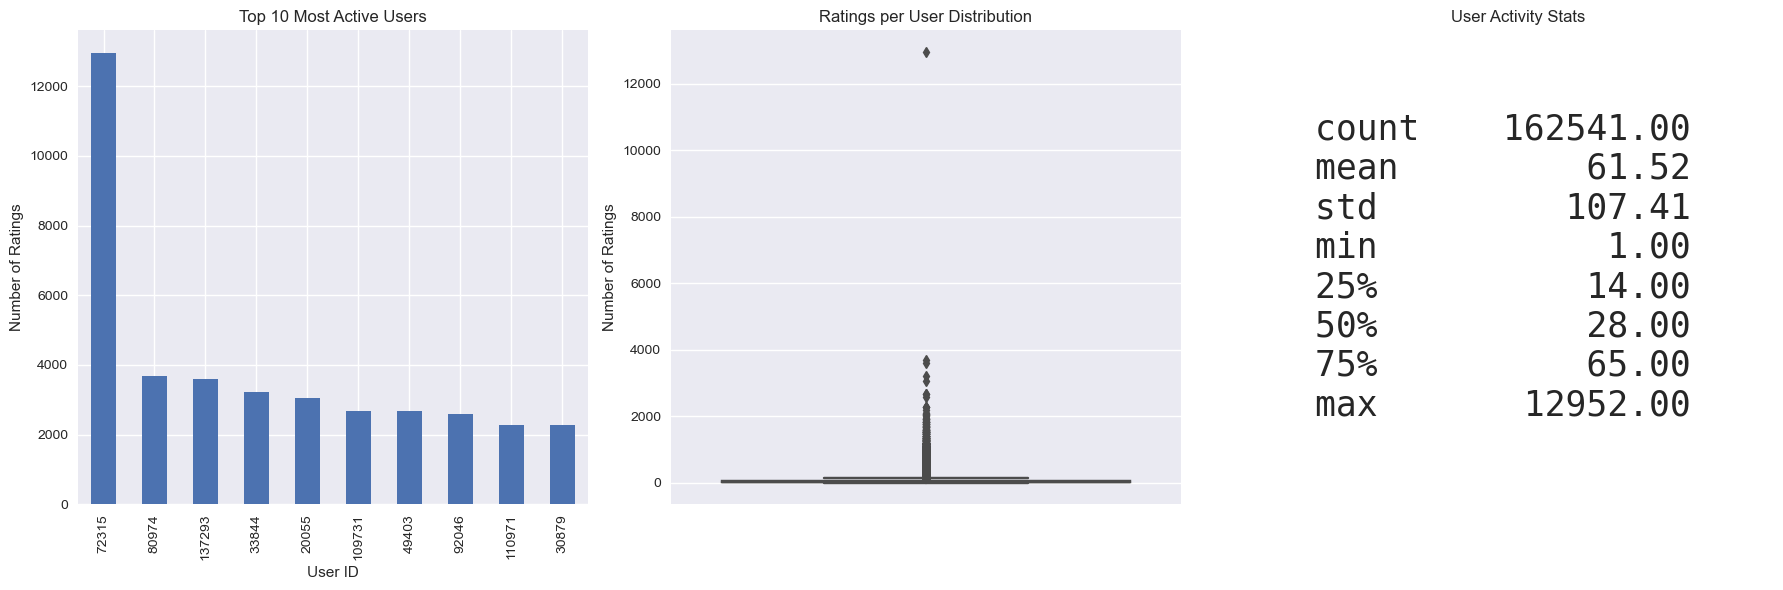

In [5]:
user_activity = train_df.groupby('userId')['rating'].count().sort_values(ascending=False)

# Create figure with 3 subplots in one row
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6), gridspec_kw={'width_ratios': [1, 1, 1]})

# Bar plot: Top 10 most active users
user_activity.head(10).plot(kind='bar', ax=ax1)
ax1.set_title('Top 10 Most Active Users')
ax1.set_xlabel('User ID')
ax1.set_ylabel('Number of Ratings')

# Box plot: Distribution of ratings per user
sns.boxplot(y=user_activity, ax=ax2)
ax2.set_title('Ratings per User Distribution')
ax2.set_ylabel('Number of Ratings')

# Text panel: Display user_activity.describe() as text in the plot
stats_text = user_activity.describe().round(2).to_string()
ax3.text(0.1, 0.5, stats_text, fontsize=25, family='monospace', va='center', ha='left')
ax3.axis('off')
ax3.set_title('User Activity Stats')

# Adjust layout and display
plt.tight_layout()
plt.show()

### Ratings per movie distribution and statistics

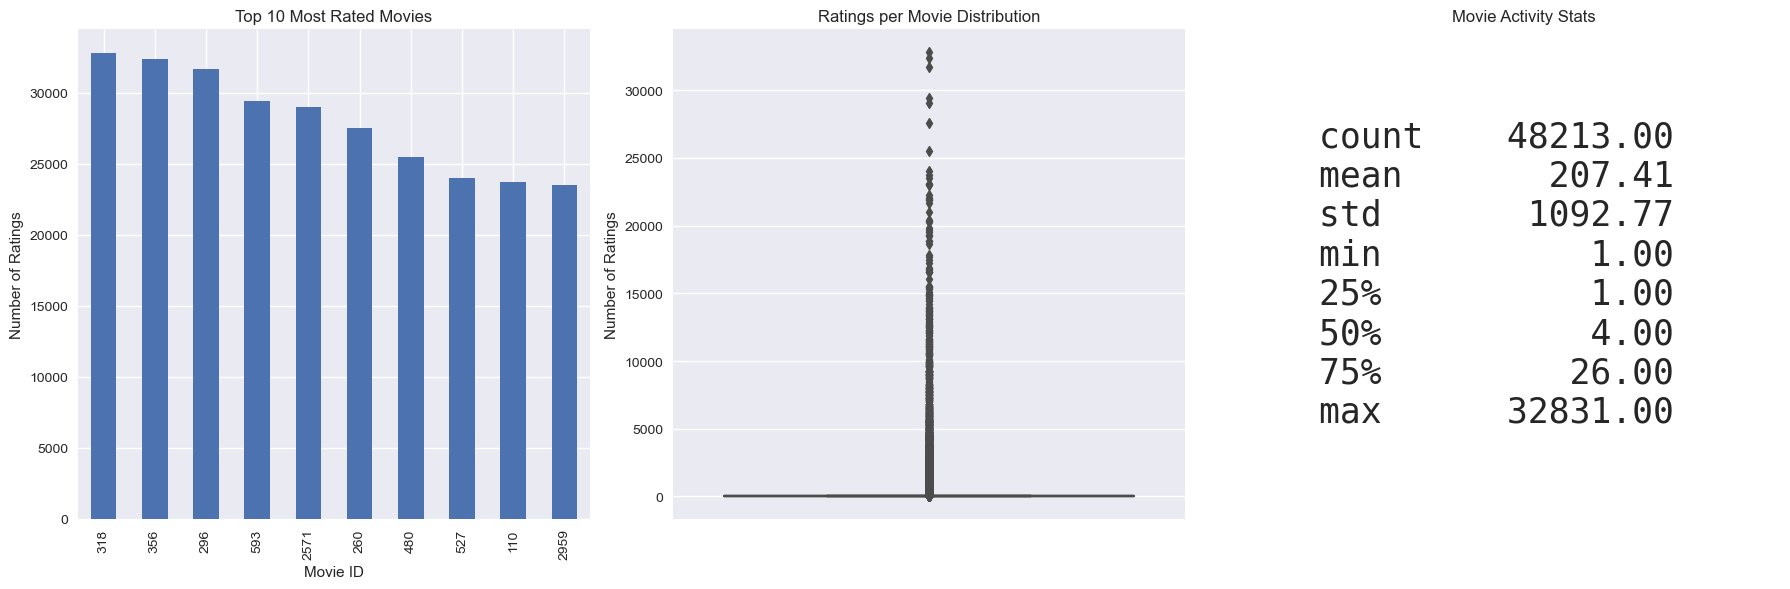

In [6]:
movie_activity = train_df.groupby('movieId')['rating'].count().sort_values(ascending=False)

# Create figure with 3 subplots in one row
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6), gridspec_kw={'width_ratios': [1, 1, 1]})

# Bar plot: Top 10 most rated movies
movie_activity.head(10).plot(kind='bar', ax=ax1)
ax1.set_title('Top 10 Most Rated Movies')
ax1.set_xlabel('Movie ID')
ax1.set_ylabel('Number of Ratings')

# Box plot: Distribution of ratings per movie
sns.boxplot(y=movie_activity, ax=ax2)
ax2.set_title('Ratings per Movie Distribution')
ax2.set_ylabel('Number of Ratings')

# Text panel: Display movie_activity.describe() as text in the plot
stats_text = movie_activity.describe().round(2).to_string()
ax3.text(0.1, 0.5, stats_text, fontsize=25, family='monospace', va='center', ha='left')
ax3.axis('off')
ax3.set_title('Movie Activity Stats')

# Adjust layout and display
plt.tight_layout()
plt.show()

### Sparsity of the user-movie matrix

In [7]:
total_possible_ratings = n_users_train * n_movies_train
sparsity = 1 - (n_ratings / total_possible_ratings)
print(f"\nSparsity of Train Data: {sparsity:.4f} ({sparsity*100:.2f}% of matrix is empty)")


Sparsity of Train Data: 0.9987 (99.87% of matrix is empty)


### Data Consistency and Validation Checks

In [8]:
# Check for users/movies in test not present in train
test_users_not_in_train = set(test_df['userId']) - set(train_df['userId'])
test_movies_not_in_train = set(test_df['movieId']) - set(train_df['movieId'])

print(f"\nUsers in Test but not in Train: {len(test_users_not_in_train)}")
print(f"Movies in Test but not in Train: {len(test_movies_not_in_train)}")

# Check for invalid ratings (assuming 0.5-5 scale, since ratings are float64)
invalid_ratings = train_df[~train_df['rating'].between(0.5, 5)]
print(f"Invalid Ratings (outside 0.5-5): {len(invalid_ratings)}")

# Check for duplicate userId-movieId pairs in train
duplicates = train_df.duplicated(subset=['userId', 'movieId']).sum()
print(f"Number of duplicate userId-movieId pairs in train: {duplicates}")


Users in Test but not in Train: 0
Movies in Test but not in Train: 5044
Invalid Ratings (outside 0.5-5): 0
Number of duplicate userId-movieId pairs in train: 0


## Modeling and predicting with SVD++

In this section, I describe the use of the SVD++ algorithm from the Surprise library to predict movie ratings for the test set in the ALX Kaggle challenge. SVD++ was chosen for its ability to handle the sparse and skewed dataset observed in EDA.

### Why SVD++?

SVD++ (Singular Value Decomposition Plus Plus) is a matrix factorization technique tailored for collaborative filtering in recommendation systems. I selected it for the following reasons:

- **Sparsity Handling**: With over 99% sparsity in the dataset (10 million ratings across 162,541 users and 48,213 movies), SVD++ effectively captures patterns in sparse data using latent factors.
- **Skewed Data**: The dataset has highly skewed user and movie activity (e.g., some users rated over 12,000 movies, while the median is 28). SVD++ is robust to such imbalances by focusing on underlying patterns rather than raw counts.
- **Implicit Feedback**: SVD++ incorporates implicit feedback (e.g., the fact that a user rated a movie), which adds valuable context beyond explicit ratings.
- **Proven Effectiveness**: Introduced by Yehuda Koren in 2008, SVD++ performed well in the Netflix Prize, making it a reliable choice for rating prediction tasks.
- **Practical Implementation**: The Surprise library offers an efficient SVD++ implementation, ideal for this competition.

### Model Application

I used SVD++ from the Surprise library, training it on the full train dataset (10 million ratings) after dropping the `timestamp` column. The model handled the 5,044 cold-start movies in the test set via latent factors.

### Steps
- **Load Data for Surprise**: Prepare the train data in the format required by the Surprise library.
- **Train SVD++ Model**: Fit the model on the train data.
- **Predict on Test Set**: Generate predictions for the test set and prepare the submission file.

In [ ]:
from surprise import SVDpp, Dataset, Reader

# Prepare train data for Surprise
reader = Reader(rating_scale=(0.5, 5.0))  # MovieLens scale
data = Dataset.load_from_df(train_df[['userId', 'movieId', 'rating']], reader)

# Define SVD++ with your best params
best_params = {
    'n_factors': 150,
    'n_epochs': 40,
    'lr_all': 0.009,
    'reg_all': 0.05
}

svdpp = SVDpp(**best_params, verbose=True)

print('Define SVD++ with your best params : Done!')

# Train on full train set
trainset = data.build_full_trainset()
svdpp.fit(trainset)

print('Train on full train set : Done!')

# Prepare test data for vectorized prediction
testset = [(row['userId'], row['movieId'], 0) for _, row in test_df.iterrows()]
predictions = svdpp.test(testset)

print('Prepare test data for vectorized prediction : Done!')

# Extract predicted ratings
test_df['rating'] = [pred.est for pred in predictions]
test_df['rating'] = test_df['rating'].clip(0.5, 5.0)  # Enforce MovieLens scale

print('Extract predicted ratings : Done!')


# Prepare Submission File
test_df['Id'] = test_df['userId'].astype(str) + '_' + test_df['movieId'].astype(str)
submission = test_df[['Id', 'rating']]
submission.to_csv('submission_svdpp.csv', index=False)

print('Submission File : Done!')

print(submission.head())

Define SVD++ with your best params : Done!


## Conclusion

The SVD++ model performed well in the ALX Kaggle challenge, achieving an RMSE of 0.8 on the test set. Despite the dataset’s challenges—over 99% sparsity, skewed user and movie activity, and 5,044 cold-start movies—SVD++ effectively captured user-movie patterns using latent factors and implicit feedback. This project highlighted the power of collaborative filtering for movie recommendation tasks.